 ## Effects of Noise on Quantum Addition: A Study Using the Draper Adder Circuit


  ### Introduction:
Quantum computing holds great promise for solving problems that are intractable for classical computers, but one of the key challenges in current quantum devices is the noise present in quantum circuits. Noise can degrade the performance of quantum algorithms, leading to errors and unreliable results. Understanding and mitigating this noise is crucial for the development of robust quantum computing systems.

  This project focuses on investigating the effects of noise on quantum addition, specifically when using the Draper adder algorithm. The Draper adder, which leverages quantum Fourier transform (QFT) for efficient addition, is a fundamental building block for more complex quantum algorithms. By introducing noise into the quantum circuit, this project aims to explore how different levels of noise impact the correctness and efficiency of quantum addition.

  ### The main objectives of this project are:

   To create a simple noise model using Pauli operators (X, Y, Z) and apply it to quantum circuits.
To build a function that transforms a general quantum circuit into a restricted gate basis.
To implement the quantum sum function using the Draper adder algorithm, incorporating Quantum Fourier Transform (QFT).
To assess the effect of noise on quantum addition and analyze how various factors (noise level, gate selection, number of gates, depth) influence the results.
In this notebook, we will demonstrate the impact of noise on quantum addition and explore potential ways to reduce the effects of noise, with the goal of optimizing quantum algorithms for real-world use.

### Background and Theory
#### The Draper Adder Algorithm
Quantum addition is a fundamental operation in quantum computing, often used as part of more complex quantum algorithms, such as Shor's algorithm for factoring large numbers. The Draper adder algorithm is one of the most well-known quantum circuits for adding two numbers.

The Draper adder utilizes the Quantum Fourier Transform (QFT) to perform addition in quantum circuits efficiently. The QFT allows the quantum circuit to represent numbers in a superposition, and by applying a series of quantum gates.

The Draper adder algorithm consists of several key steps:

Initialize the quantum registers: The input numbers are encoded into the quantum registers.
Apply the QFT: The Quantum Fourier Transform is applied to the quantum registers to prepare them for addition.
Carry operation: The carry bits are computed, and the addition is performed using controlled gates.
Inverse QFT: The inverse QFT is applied to the quantum registers to retrieve the final sum.
#### Quantum Gates and Gate Basis
In quantum circuits, a set of gates is used to manipulate qubits and implement algorithms. The gate set is referred to as the gate basis and forms the foundation for the quantum processor. For this project, we are working with the following gate basis:

CX (CNOT): A two-qubit gate that flips the state of the target qubit if the control qubit is in the state |1>.

ID (Identity): A single-qubit gate that does nothing to the qubit.

RZ (Rotation about the Z axis): A single-qubit gate that rotates the qubit around the Z axis of the Bloch sphere.

SX (Square Root of X): A single-qubit gate that applies a half-bit flip to the qubit.

X (Pauli X): A single-qubit gate that flips the qubit's state (bit-flip operation).
Each gate serves a different purpose, and together they can represent any quantum operation. Transforming a quantum circuit into a restricted gate basis is a key part of optimizing the circuit and ensuring it can be implemented on a real quantum computer with limited gate sets.

#### Noise Model
In this project, I modeled noise using Pauli operators (X, Y, Z) to simulate common types of quantum errors. However, for the implementation of single-qubit errors, instead of using the standard pauli gate, I utilized the rotation gates. Because using pauli gates directly resulted in too much fluctuation that I couldn't get anything meaningful. 
The rotation gates has the general form:

$R_{\sigma}(\theta) = e^{-i \frac{\theta}{2} \sigma}$
 
where 
𝜃
θ is the angle of rotation, and $\sigma$s are the Pauli operators. While the Pauli gates only flips the state of the qubit, the rotation gates performs a more general rotation around the X, Y or Z-axis of the Bloch sphere, providing a finer level of noise simulation in this context.

This substitution means that instead of simply flipping the qubit's state (as would occur with a Pauli-X error), I simulate noise that causes the qubit to undergo a random rotation around the X-axis. This approach can help to better simulate the noise that occurs in real quantum devices, where qubits may experience more general errors (e.g., rotations) rather than simple bit-flips.

In the code, instead of applying the Pauli gates when noise occurs, I apply the rotation gate with a randomly chosen angle, scaled by the noise probability. This introduces a more continuous range of errors, which is often more representative of real-world noise patterns in quantum hardware.

In [134]:
%pip install qiskit qiskit-aer


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: D:\Documents\QC\QOSF\venv\Scripts\python.exe -m pip install --upgrade pip


In [11]:
# Importing necessary packages

import time, datetime
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit.visualization import array_to_latex, plot_bloch_vector, plot_bloch_multivector, plot_histogram
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, synthesis
from qiskit.circuit import Parameter
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library import XGate, YGate, ZGate, CXGate, CZGate, U3Gate, \
                                RYGate, RXGate, RZGate, CRYGate, CRXGate, CRZGate
from qiskit_aer import AerSimulator, Aer, StatevectorSimulator
from qiskit.primitives import Sampler, StatevectorSampler, Estimator
import qiskit.quantum_info as qi

### Implementation of the Adder Circuit

Following codes implements the draper adder. First let's build the QFT circuit.
[Ref 1](https://github.com/Qiskit/qiskit/blob/stable/1.2/qiskit/circuit/library/arithmetic/adders/draper_qft_adder.py#L24-L116)

[Ref 2](https://pennylane.ai/qml/demos/tutorial_qft_arithmetics/#adding-two-different-registers)

[Ref 3](https://dannasman.github.io/qft-adder)

[ref 4](https://arxiv.org/pdf/1411.5949)

In [2]:
# defining QFT need to describe it. from Thomas wong book

def QFT(n: int,use_swaps: bool = True) -> QuantumCircuit:
    """
    Parameters
    ----------
    n : int
        The number of qubits on which to perform the Quantum Fourier Transform.
    use_swaps: bool
        To instruct whether you will use swaps or not.

    Returns
    -------
    QuantumCircuit
        A QuantumCircuit object representing the QFT on `n` qubits.
    """
    
    circuit = QuantumCircuit(n,name="QFT")
    for j in reversed(range(n)):
        circuit.h(j)
        for k in range(j):
            lam = np.pi * (2.0 ** (k - j))
            circuit.cp(lam, k, j)
    if use_swaps:
        for i in range(n // 2):
            circuit.swap(i, n - i - 1)
    return circuit
# Example
QFT(3).draw()

┌───┐   
q_0: ──────■──────────────────────■───────┤ H ├─X─
           │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────┼────────■───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/4)  │P(π/2) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘

Now before implementing the adder let's write a function to basis encode the numbers to be added.

In [4]:
def basis_encoding(value: int) -> Tuple[int, QuantumCircuit]:
    """Encodes an integer as a quantum basis state."""
    num_qubits = max(1,value.bit_length())
    bin_form = bin(value)[2:][::-1] # Reversed binary value
    circuit = QuantumCircuit(num_qubits,name="{}".format(value))

    for i, bit in enumerate(bin_form):
        if bit == '1':
            circuit.x(i)

    return num_qubits, circuit

And finally I build the adder.

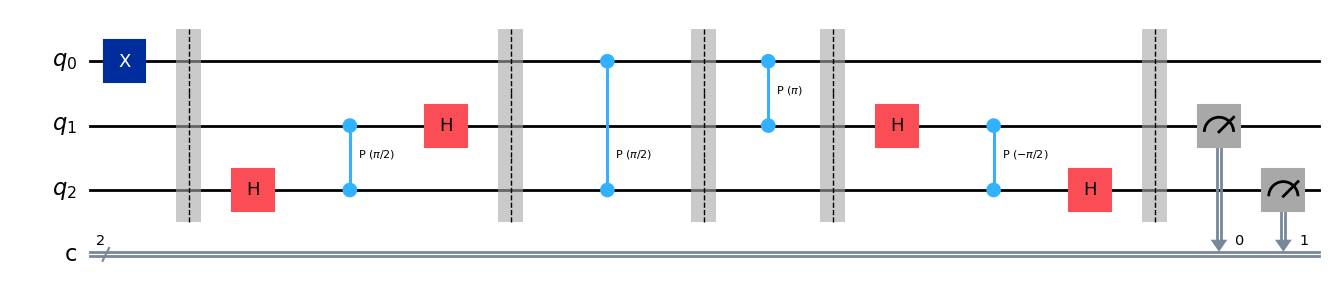

In [5]:
def adder(a: int, b: int) -> QuantumCircuit:
    """
    Constructs a quantum circuit for the Draper adder, which adds two integers `a` and `b` of the same size in binary
    using quantum phase estimation and the Quantum Fourier Transform (QFT). 

    Args:
        a (int): The first integer input for addition.
        b (int): The second integer input for addition.

    Returns:
        QuantumCircuit: A quantum circuit that performs the addition `a + b` in the computational basis.
    """
    
    # Number of qubits needed for each integer's encoding
    num_qubits_a, a_encoded = basis_encoding(a)
    num_qubits_b, b_encoded = basis_encoding(b)

    # Register for `a`, `b`, and an additional qubit for the QFT
    reg_a = list(range(num_qubits_a))
    reg_b = list(range(num_qubits_a, num_qubits_a + num_qubits_b))
    target = num_qubits_a + num_qubits_b # which stores the carry

    # Initialize quantum circuit
    qc = QuantumCircuit(num_qubits_a + num_qubits_b + 1, num_qubits_b + 1)

    # Step 1: Encode `a` and `b` in quantum registers
    qc.append(a_encoded, reg_a)
    qc.append(b_encoded, reg_b)
    qc.barrier()

    # Step 2: Apply QFT on `b` register plus an additional target qubit
    qc.append(QFT(num_qubits_b + 1, use_swaps=False), reg_b + [target])
    qc.barrier()

    # Step 3: Controlled phase rotations from `a` qubits onto the most significant bit of `b`
    for j in range(num_qubits_a):
        lam = np.pi / (2 ** (j + 1))
        qc.cp(lam, reg_a[num_qubits_a - j - 1], target)
    qc.barrier()

    # Step 4: Apply phase rotations from each `a` qubit onto each corresponding `b` qubit
    for j in range(num_qubits_a):
        for k in range(num_qubits_b - j):
            lam = np.pi / (2 ** k)
            qc.cp(lam, reg_a[j], reg_b[j + k])
        qc.barrier()

    # Step 5: Apply inverse QFT on the `b` register plus the target qubit
    qc.append(QFT(num_qubits_b + 1, use_swaps=False).inverse().to_gate(), reg_b + [target])
    qc.barrier()

    # Step 6: Measure the `b` register to obtain the result `a + b`
    qc.measure(reg_b + [target], range(num_qubits_b + 1))

    return qc.decompose(gates_to_decompose = ["{}".format(b),"{}".format(a),'QFT','QFT_dg'])

# Example
a = 1
b = 0
qc = adder(a, b)
qc.draw('mpl')

Then I test the adder. But before testing it, I defined a custom function to abstract away the details code implementation of sampling. 

In [3]:
def sample(qc: QuantumCircuit, shots: int = 1024) -> dict:
    """
    Runs a quantum circuit using a simulator and returns the measurement results.

    Args:
        qc (QuantumCircuit): The quantum circuit to execute.
        shots (int): The number of shots to execute the circuit.

    Returns:
        dict: A dictionary with counts of measurement results.
    """
    sim = Aer.get_backend('aer_simulator')
    t = transpile(qc, sim)
    # Run the circuit with the specified number of shots
    res = sim.run(t, shots=shots).result().get_counts()
    return res

Now lets test the adder

In [139]:
def test_cases(adder_function, max_value=16):
    qcs = []
    numbers = []
    expected_sums = []
    a = 1
    while a <= max_value:
        for b in range((a >> 1), a):
            expected_sum = (a - 1) + b

            # Generate the Draper adder circuit
            qc = adder_function(a - 1, b) 
            qcs.append(qc)
            numbers.append([a-1,b])
            expected_sums.append(expected_sum)
        a <<= 1
    return zip(qcs, numbers, expected_sums)
    
def test_adder(adder_function, max_value=16, Print = True):
    """
    Tests the Draper adder for a range of integers and returns results for error analysis.

    Args:
        adder_function (function): Function to generate the Draper adder circuit.
        sample_function (function): Function to execute the circuit and return sample counts.
        max_value (int): Maximum range for testing (powers of 2 up to max_value).
        
    Returns:
        list: A list of dictionaries containing each test case result, expected sum, 
              measured sum, and whether it passed.
    """
    
    for qc, nums, expected_sum in test_cases(adder_function, max_value):
        
        a, b = nums
        # Get the sample counts from the circuit
        counts = sample(qc)

        # Determine the most common result as the measured outcome
        measured_result = max(counts, key=counts.get)  # Most frequent result
        measured_sum = int(measured_result, 2)
        
        if print:
            print(f"{a} + {b} = {measured_sum}")

test_adder(adder)

0 + 0 = 0
1 + 1 = 2
3 + 2 = 5
3 + 3 = 6
7 + 4 = 11
7 + 5 = 12
7 + 6 = 13
7 + 7 = 14
15 + 8 = 23
15 + 9 = 24
15 + 10 = 25
15 + 11 = 26
15 + 12 = 27
15 + 13 = 28
15 + 14 = 29
15 + 15 = 30


#### Following part implements noise model 
alpha -> probability of error after single qubit error
beta -> after 2 qubit gate.

#### Then to calculate fidelity of the noisy output, I may use quantum state tomography to calculate density matrix from the sample output, then use fidelity formula
$F(|\psi><\psi|, \sigma) = <\psi|\sigma|\psi>$

### Two-qubit gate error is a significant contributor to error propagation in circuits with high depths

#### Noise Model Integration
The noise is added probabilistically based on the gate type.
For single-qubit gates, random Pauli errors (𝑅𝑋, 𝑅𝑌, or 𝑅𝑍) are applied based on the probability alpha.
For two-qubit gates, controlled Pauli errors (e.g., CRX, CRZ, CRY) are applied based on the probability beta.
The errors are selected randomly from predefined sets of single-qubit and two-qubit gates, and the angle for the error is scaled by 𝜋⋅𝛼 or 𝜋⋅𝛽 to control the strength of the noise.
The function returns the noisy quantum circuit with these errors added after each gate in the input circuit.
Here’s an example of how to apply the noise model to the quantum sum circuit:

In [183]:
def apply_noise(qc: QuantumCircuit, alpha: float, beta: float) -> QuantumCircuit:
    """
    Manually applies noise to the given quantum circuit with probabilities `alpha` for single-qubit gates and `beta` for two-qubit gates.

    Args:
        qc (QuantumCircuit): The input quantum circuit to which noise is added.
        alpha (float): Probability of applying a single-qubit error after each single-qubit gate.
        beta (float): Probability of applying a two-qubit error after each two-qubit gate.

    Returns:
        QuantumCircuit: The noisy version of the input quantum circuit.
    """
    # Create a new circuit to apply noise manually
    errors1 = [RYGate, RXGate, RZGate]
    errors2 = [CRXGate, CRZGate, CRYGate]
    noisy_qc = QuantumCircuit(qc.num_qubits, qc.num_clbits)
    for inst, qargs, cargs in qc.data:
        # Add the gate to the new circuit
        noisy_qc.append(inst, qargs, cargs)

        # Determine if this is a single- or two-qubit gate
        num_qubits = len(qargs)
        # Apply noise based on the gate type
        if num_qubits == 1 and np.random.rand() < alpha:
            # Add single-qubit error probabilistically
            select = np.random.choice([0,1,2])
            angle = np.random.rand(1,1)*np.pi*alpha 
            noisy_qc.append(errors1[select](list(angle[0])[0]), [qargs[0]])

        elif num_qubits == 2 and np.random.rand() < beta:
            # Add two-qubit error probabilistically (e.g., CX error)
            select = np.random.choice([0,1,2])
            angle = np.random.rand(1,1)*np.pi*beta
            noisy_qc.append(errors2[select](list(angle[0])[0]), [qargs[0], qargs[1]])
    return noisy_qc

# Example usage
a, b = 5, 7
qc = adder(a, b)
alpha = 0.1
beta = 0.01

noisy_qc = apply_noise(qc, alpha, beta)
# display(noisy_qc.draw('mpl'))
sample(noisy_qc,100000),sample(qc,100000)

({'1100': 99996, '0100': 4}, {'1100': 100000})

#### Gate Basis Transformation
Following Part will implement decomposition of general circuits to available gates {CX,ID,RZ,SX,X}. For now, it can decompose all single qubit unitaries. But not all two qubit unitaries. But for adder circuit, it is good to go.

In [184]:
from qiskit.circuit.library import RZGate, SXGate, XGate, CXGate


def transform_to_allowed_basis(input_circuit):
    """
    Decomposes an input quantum circuit into a set of allowed gates: {CX, ID, RZ, SX, X}.
    
    Parameters:
        input_circuit (QuantumCircuit): The input circuit with arbitrary gates.
    
    Returns:
        QuantumCircuit: A new circuit decomposed into the allowed gate set.
    """
    
    # Define the allowed gates set
    allowed_gates = {"cx", "id", "rz", "sx", "x"}
    
    def H(qc, qubit):
        qc.rz(np.pi/2, qubit)
        qc.sx(qubit)
        qc.rz(np.pi/2, qubit)

    def Y(qc, qubit):
        decomposed_circuit.rz(np.pi, qubits[0])
        decomposed_circuit.x(qubits[0])

    def SXDG(qc, qubit):
        qc.rz(-np.pi, qubit)
        qc.sx(qubit)
        qc.rz(-np.pi, qubit)

    def U(theta, phi, lam, qc, qubit):
        qc.rz(lam, qubit)
        qc.sx(qubit)
        qc.rz(theta + np.pi, qubit)
        qc.sx(qubit)
        qc.rz(phi + 3*np.pi, qubit)
        
    def SWAP(qc, qubits):
        qc.cx(qubits[0], qubits[1])
        qc.cx(qubits[1], qubits[0])
        qc.cx(qubits[0], qubits[1])

    
    def decompose_single_qubit_gates(decomposed_circuit, inst, gate_name, qubits):
            
        if gate_name == "h":
            H(decomposed_circuit, qubits[0])
            
        elif gate_name == "sxdg": 
            SXDG(decomposed_circuit, qubits[0])

        elif gate_name == "z":
            decomposed_circuit.rz(np.pi, qubits[0])

        elif gate_name == "s": 
            decomposed_circuit.rz(np.pi / 2, qubits[0])

        elif gate_name == "sdg": 
            decomposed_circuit.rz(-np.pi / 2, qubits[0])

        elif gate_name == "t":
            decomposed_circuit.rz(np.pi / 4, qubits[0])

        elif gate_name == "tdg":
            decomposed_circuit.rz(-np.pi / 4, qubits[0])

        elif gate_name == "p": 
            decomposed_circuit.rz(inst.params[0], qubits[0])

        elif gate_name == "y":
            Y(decomposed_circuit, qubits[0])

        elif gate_name == "u":  
            # U3(θ, φ, λ) as a general rotation
            theta, phi, lam = inst.params
            U(theta, phi, lam, decomposed_circuit, qubits[0])

        else: 
            # ALl other single qubit gates are converted to euler angles to use in U 
            decomposer = synthesis.OneQubitEulerDecomposer('ZYZ')
            theta, phi, lam = decomposer.angles(qi.Operator(inst))
            U(theta, phi, lam, decomposed_circuit, qubits[0])
            
    def decompose_multi_qubit_gates(decomposed_circuit, inst, gate_name, qubits):
        
        if gate_name == "swap":
            SWAP(decomposed_circuit, qubits)
            
        elif gate_name == "cz":
            H(qubits[1])
            decomposed_circuit.cx(qubits[0], qubits[1])
            H(qubits[1])

        elif gate_name == "cy":
            decomposed_circuit.rz(-np.pi/2, qubits[1])
            decomposed_circuit.cx(qubits[0], qubits[1])
            decomposed_circuit.rz(np.pi/2, qubits[1])
            
        elif gate_name == "cp":
            angle = inst.params[0]/2
            decomposed_circuit.rz(angle, qubits[0])
            decomposed_circuit.cx(qubits[0], qubits[1])
            decomposed_circuit.rz(-angle, qubits[1])
            decomposed_circuit.cx(qubits[0], qubits[1])
            decomposed_circuit.rz(angle, qubits[1])
            
        elif gate_name == "cs":
            angle = np.pi/4
            decomposed_circuit.rz(angle, qubits[0])
            decomposed_circuit.cx(qubits[0], qubits[1])
            decomposed_circuit.rz(-angle, qubits[1])
            decomposed_circuit.cx(qubits[0], qubits[1])
            decomposed_circuit.rz(angle, qubits[1])

        else:
            gate = synthesis.TwoQubitBasisDecomposer(inst)
            decomposed_circuit.append(gate,qubits)
            print(gate)
#             raise ValueError(f"Gate {inst} is not supported for decomposition or is unknown.")
        
        

    # Create a new circuit with the same number of qubits
    decomposed_circuit = QuantumCircuit(input_circuit.num_qubits)
    
    # Add classical bits explicitly
    if input_circuit.cregs:
        decomposed_circuit.add_register(input_circuit.cregs[0])
    
    for inst, qubits, clbits in input_circuit.data:
        gate_name = inst.name.lower()

        # Check if the gate is already in the allowed set
        if gate_name in allowed_gates:
            decomposed_circuit.append(inst, qubits)
            
        elif gate_name == "barrier":
            decomposed_circuit.append(inst, qubits)
            continue

        elif gate_name == "measure":
            decomposed_circuit.measure(qubits[0], clbits[0])
            continue
        
        if inst.num_qubits == 1:
            decompose_single_qubit_gates(decomposed_circuit, inst, gate_name, qubits)

        else:
            decompose_multi_qubit_gates(decomposed_circuit, inst, gate_name, qubits)

    return decomposed_circuit


Let's test the decomposer. Here I have defined a quantum circuit

In [157]:
qc = QuantumCircuit(3)
# qc.u(np.pi, np.pi/2, np.pi/4 ,0)
# qc.p(np.pi,0)
# qc.y(0)
qc.append(StatePreparation([1/np.sqrt(2),1/np.sqrt(2)]),[0])
# qc.cp(np.pi,0,1)
# qc.cp(a, 0,1)
# qc.crz(a,0,1)
# qc.iswap(0,1)
# qc.ch(0,1)
# qc.measure_all()
qc.draw()


┌────────────────────────────────────┐
q_0: ┤ State Preparation(0.70711,0.70711) ├
     └────────────────────────────────────┘
q_1: ──────────────────────────────────────
                                           
q_2: ──────────────────────────────────────

Now to be confirm that the decomposer is working, I have appended the inverse of the decomposed circuit with the input circuit. If it return the zero state then the decomposer is working fine. In this case, it is working. 

In [161]:
display(qc.draw())
display(decompose_to_allowed_gates(qc).draw())
qc.append(transform_to_allowed_basis(qc).inverse(),[0,1,2])
qc.measure_all()
sample(qc,1000)

┌────────────────────────────────────┐
q_0: ┤ State Preparation(0.70711,0.70711) ├
     └────────────────────────────────────┘
q_1: ──────────────────────────────────────
                                           
q_2: ──────────────────────────────────────

┌───────┐┌────┐┌──────────┐┌────┐┌────────┐
q_0: ┤ Rz(0) ├┤ √X ├┤ Rz(3π/2) ├┤ √X ├┤ Rz(3π) ├
     └───────┘└────┘└──────────┘└────┘└────────┘
q_1: ───────────────────────────────────────────
                                                
q_2: ───────────────────────────────────────────

{'000': 1000}

#### Combined Quantum Circuit
Now, I can combine all the steps:

- Build the quantum adder function.
- Transform the circuit into the restricted gate basis.
- Add noise using the noise model.

In [172]:
def final_quantum_adder(a, b, alpha, beta):
    """
    Creates a complete quantum addition circuit with noise and gate transformation.
    
    Args:
        a (int): First number to add.
        b (int): Second number to add.
        alpha (float): Probability of a single-qubit error.
        beta (float): Probability of a two-qubit error.
        
    Returns:
        QuantumCircuit: The noisy, gate-transformed quantum addition circuit.
    """
    # Step 1: Build the quantum sum circuit
    qc = adder(a, b)
    
    # Step 2: Transform to restricted gate basis
    noisy_qc = transform_to_allowed_basis(qc)
    
    # Step 3: Apply noise
    final_qc = apply_noise(noisy_qc, alpha, beta)
    
    return final_qc


In [185]:
import numpy as np

def calculate_fidelity(expected_counts, measured_counts, shots):
    """
    Calculate fidelity between expected and measured counts.
    
    Args:
        expected_counts (dict): Ideal measurement results.
        measured_counts (dict): Noisy measurement results.
        shots (int): Total number of shots.

    Returns:
        float: Fidelity value between 0 and 1.
    """
    fidelity = 0
    for state, count in expected_counts.items():
        p_ideal = count / shots
        fidelity = measured_counts.get(state, 0) / shots 
    return fidelity


In [191]:
def fidelity_vs_noise(adder, noise_levels, scale = 2, shots=1000):
    fidelities = []
    for noise in noise_levels:
        noisy_adder = final_quantum_adder(a, b, noise, scale*noise)
        expected_counts = sample(adder, shots)
        noisy_counts = sample(noisy_adder, shots)

        fidelity = calculate_fidelity(expected_counts, noisy_counts, shots)
        fidelities.append(fidelity)
        
    x = noise_levels
    y = fidelities
    plt.scatter(x, y)
    plt.xlabel('Noise Level')
    plt.ylabel('Fidelity')
    plt.title(f'Fidelity vs Noise Level for addition of ({a}, {b})')
    plt.grid(True)
    plt.show()
    return fidelities

In [190]:
def fidelity_vs_gate_count_and_depth(adder_function, max_value=16, noise=0.01, scale = 2, shots=1000):
    fidelities = []
    gate_counts = []
    depths = []
    for qc, nums, _ in test_cases(adder_function, max_value):
        a, b = nums
        
        # Noisy simulation
        noisy_adder = final_quantum_adder(a, b, noise, scale*noise)
        # Measure gate count
        gate_counts.append(sum(noisy_adder.count_ops().values()))
        # Measure depth
        depths.append(noisy_adder.depth())
        expected_counts = sample(qc, shots)  # Ideal counts
        
        counts = sample(noisy_adder, shots)
        
        fidelity = calculate_fidelity(expected_counts, counts, shots)
        fidelities.append(fidelity)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    # Plot in the first subplot
    axes[0].plot(gate_counts, fidelities, color="blue", marker='o', label="Fidelity vs gate counts")
    axes[0].set_title(f'Fidelity vs Gate Count for Noise Level {noise_level}')
    axes[0].set_xlabel('Gate Count')
    axes[0].set_ylabel('Fidelity')
    axes[0].legend()
    axes[0].grid(True)

    # Plot in the second subplot
    axes[1].plot(depths, fidelities, color="red", marker='o', label="Fidelity vs depth")
    axes[1].set_title(f'Fidelity vs Depth for Noise Level {noise_level}')
    axes[1].set_xlabel('Depth')
    axes[1].set_ylabel('Fidelity')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    return fidelities, gate_counts, depths


In [166]:
import pandas as pd

def plot_rolling_average(data, window_size):
    df = pd.DataFrame(data, columns=['Values'])

    df['Rolling_Average'] = df['Values'].rolling(window=window_size).mean()

    # Display the result
    plt.plot(df)
    plt.show()
def corr_coeff(x, y):
    # -1<= coeff <=1
    # High negative correlation would imply that noise is directly impacting fidelity.
    data = {'x': x, 'y': y}
    df = pd.DataFrame(data)

    # Calculate pearson correlation coefficient
    correlation = df['x'].corr(df['y'])
    print("Correlation coefficient:", correlation)
# corr_coeff(fid_vs_noise, noise_levels)
# plot_rolling_average(fid_vs_noise, 3)

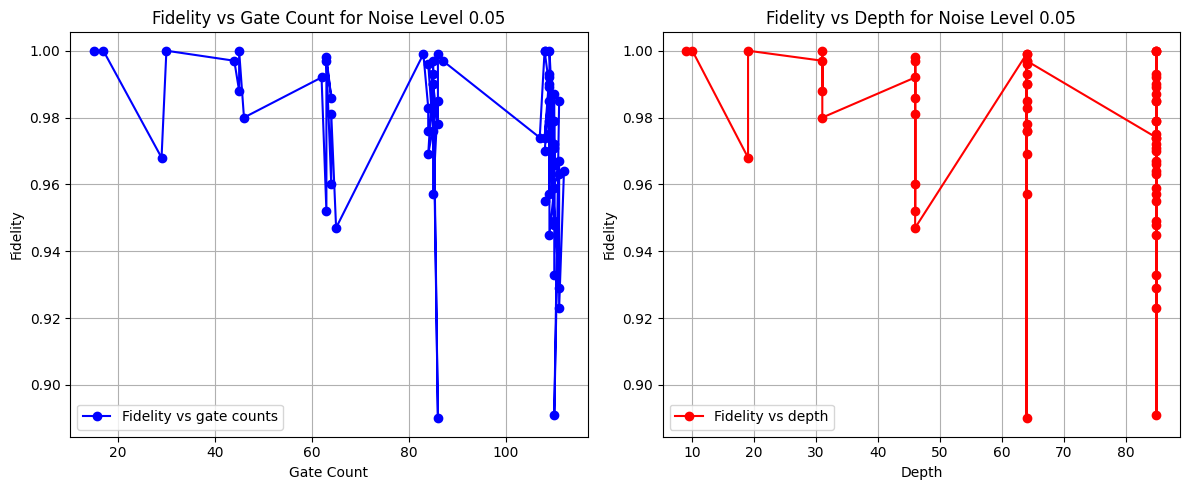

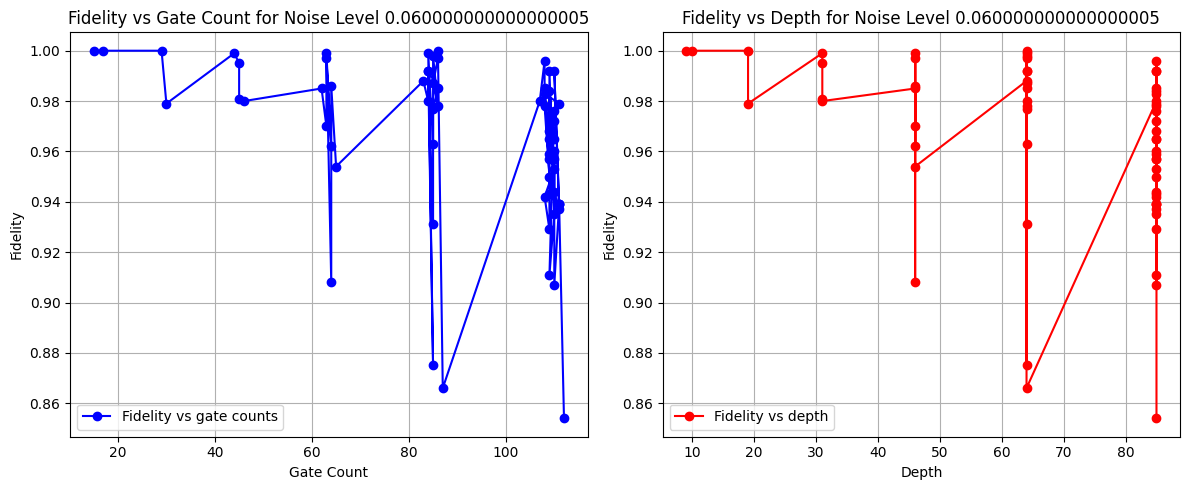

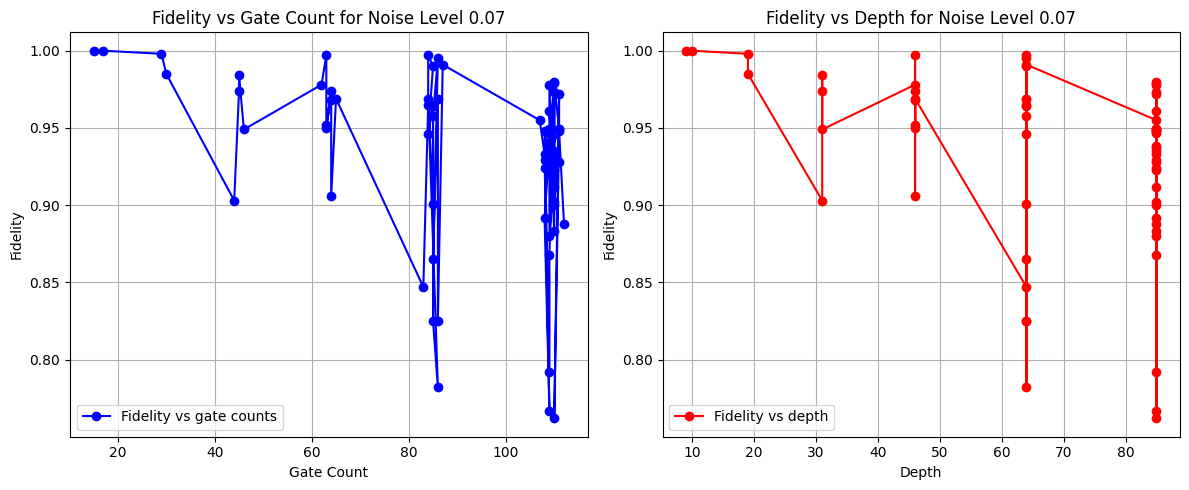

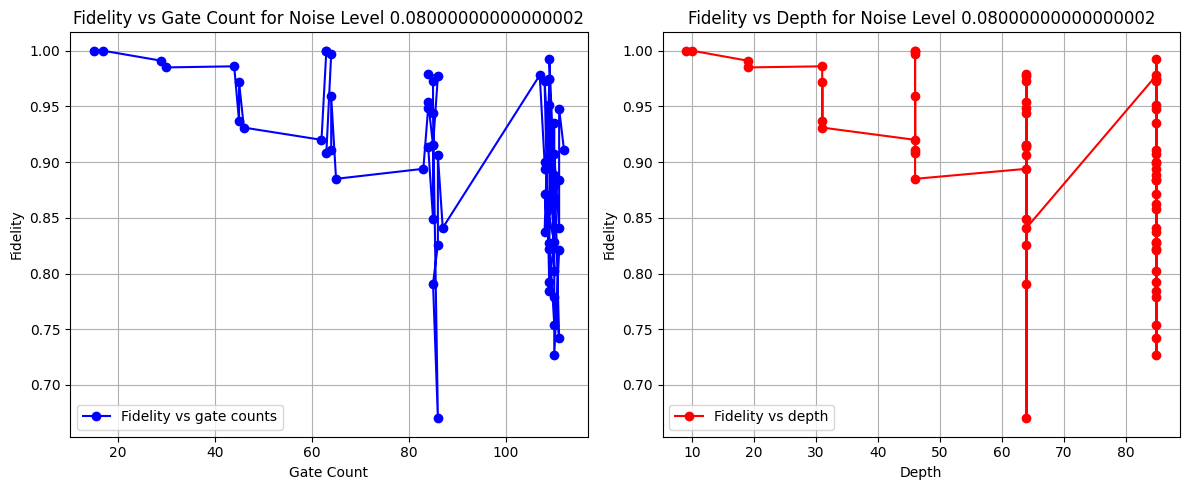

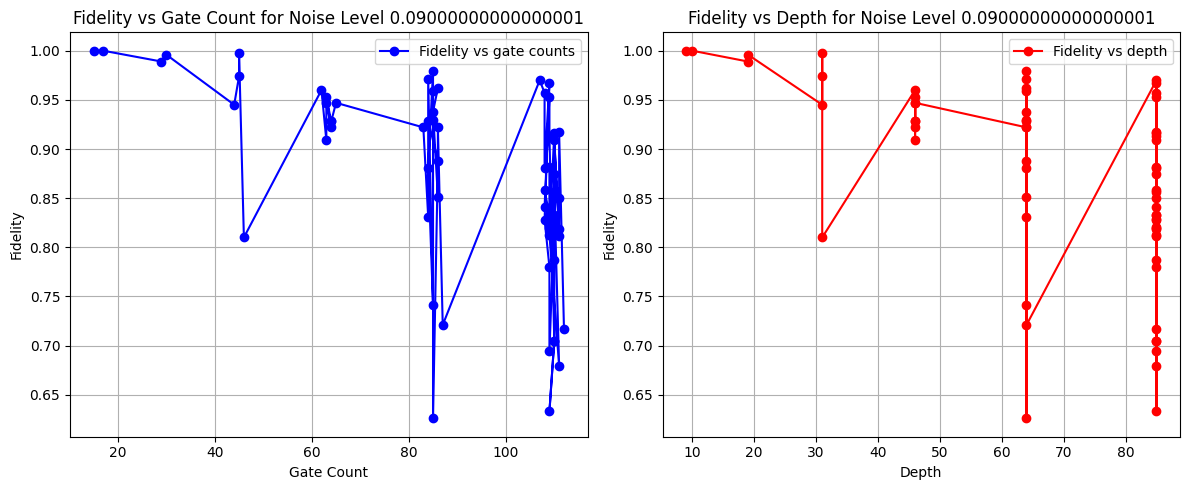

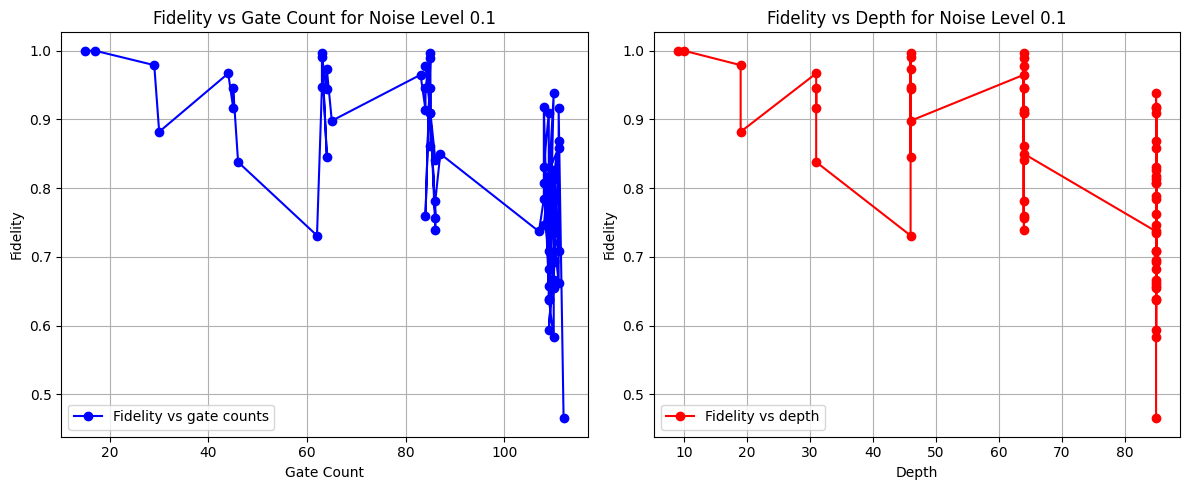

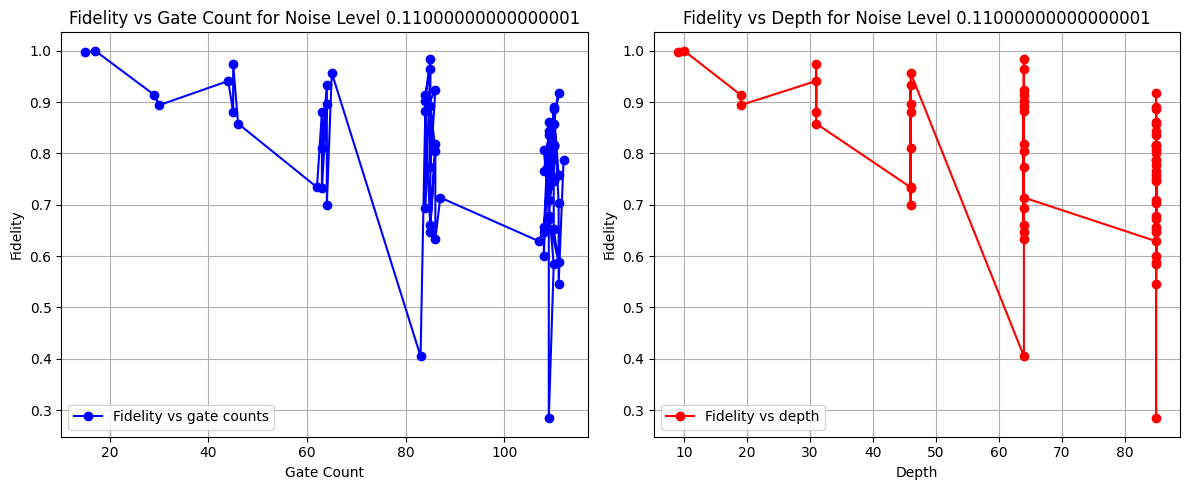

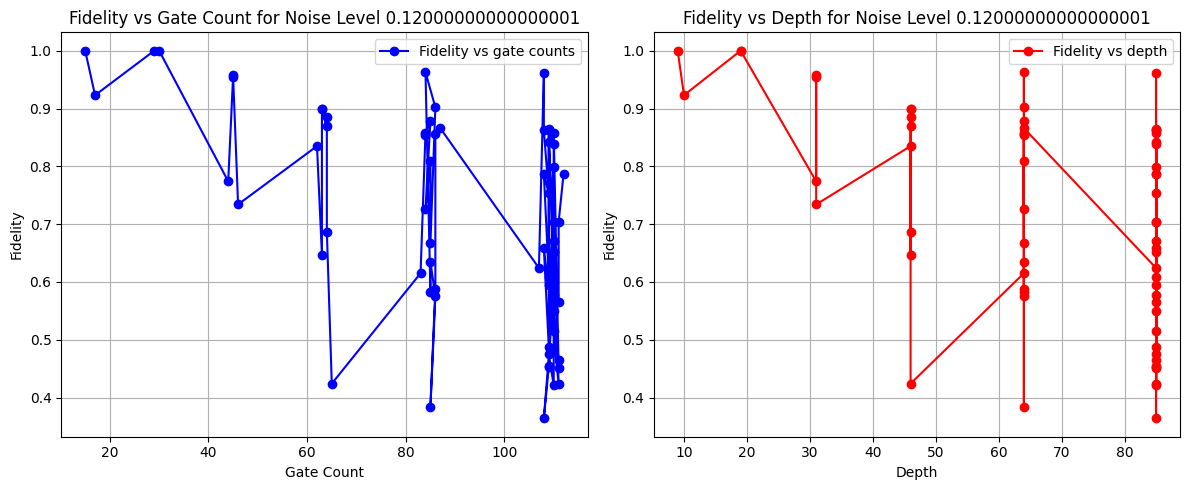

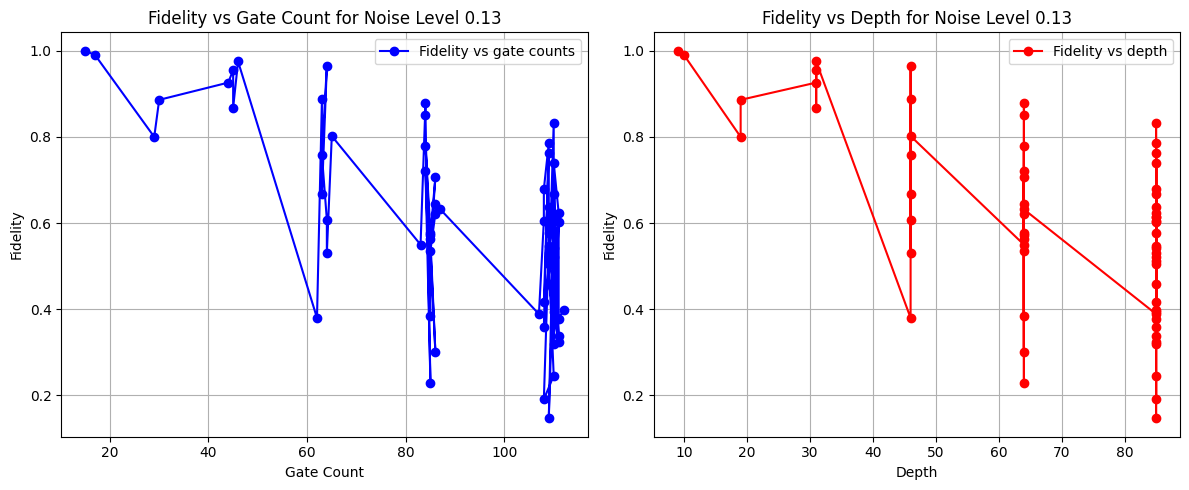

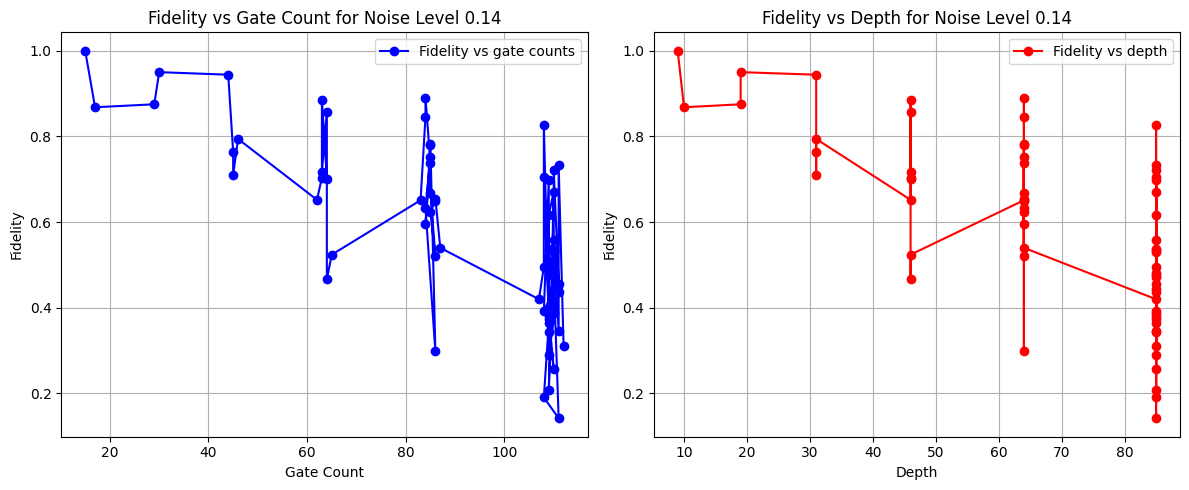

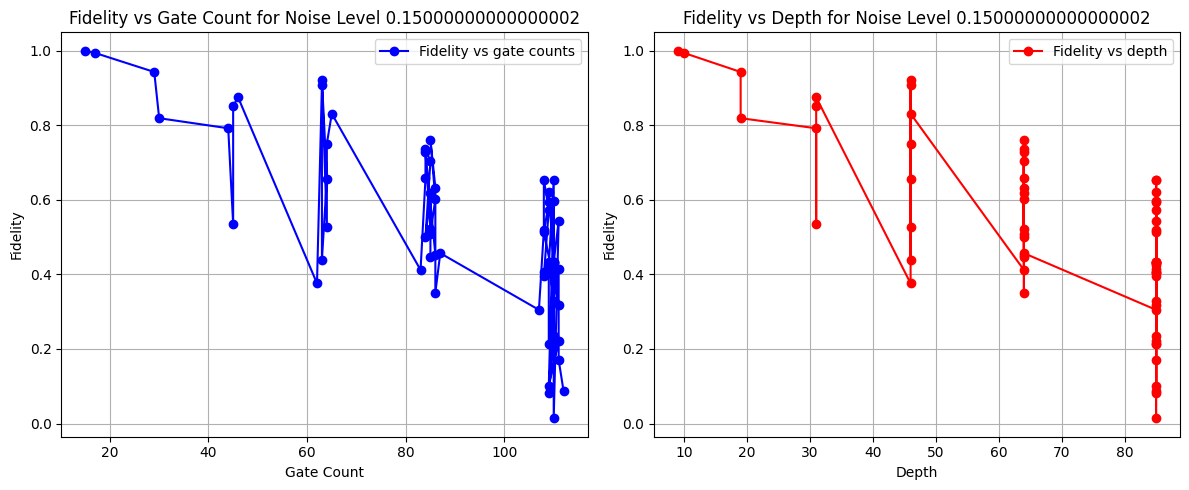

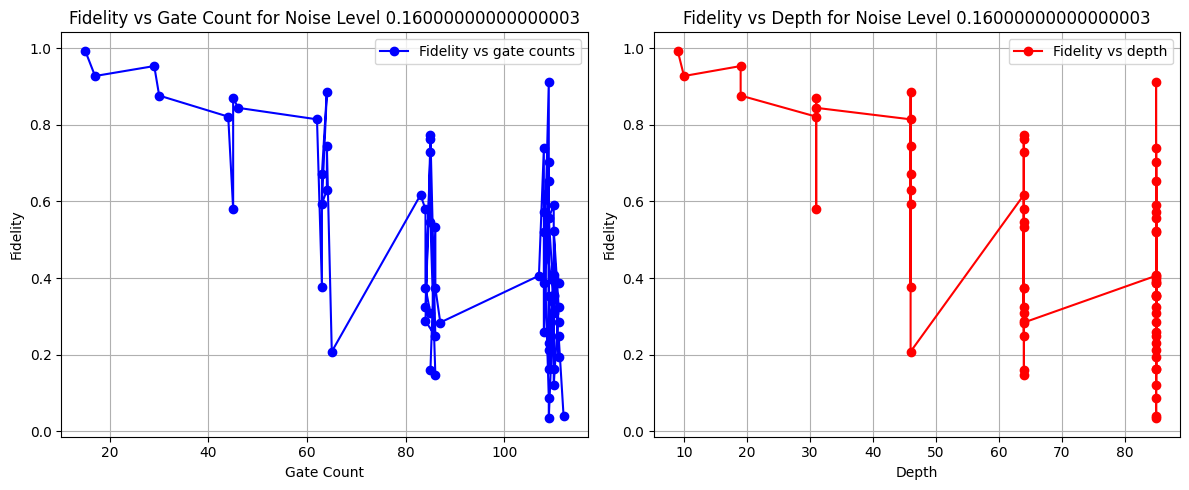

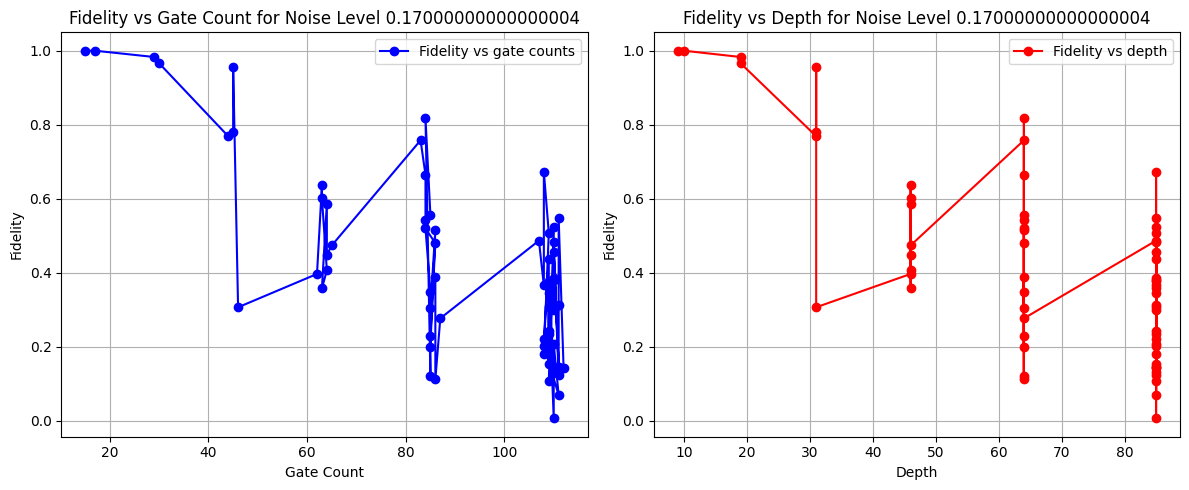

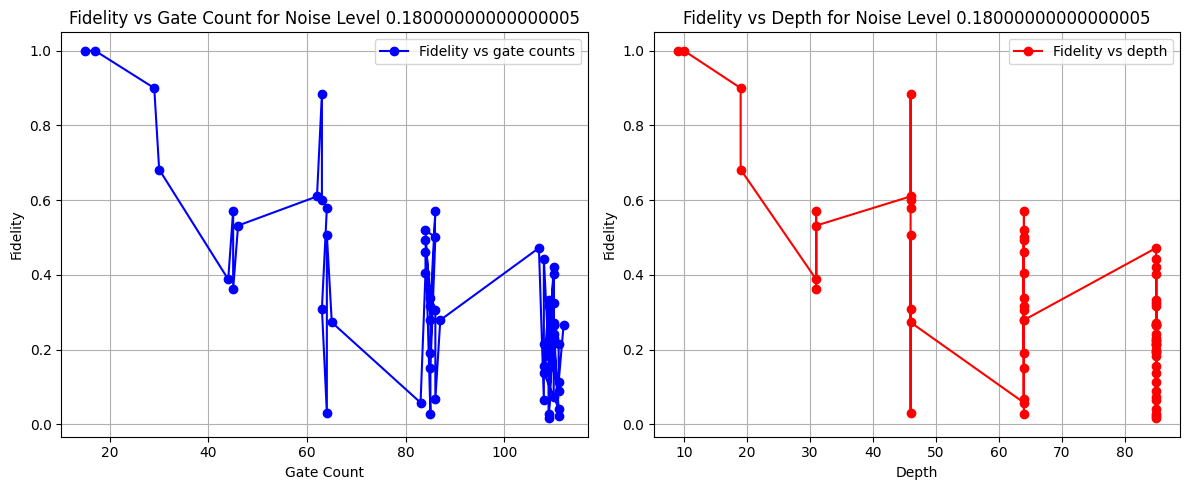

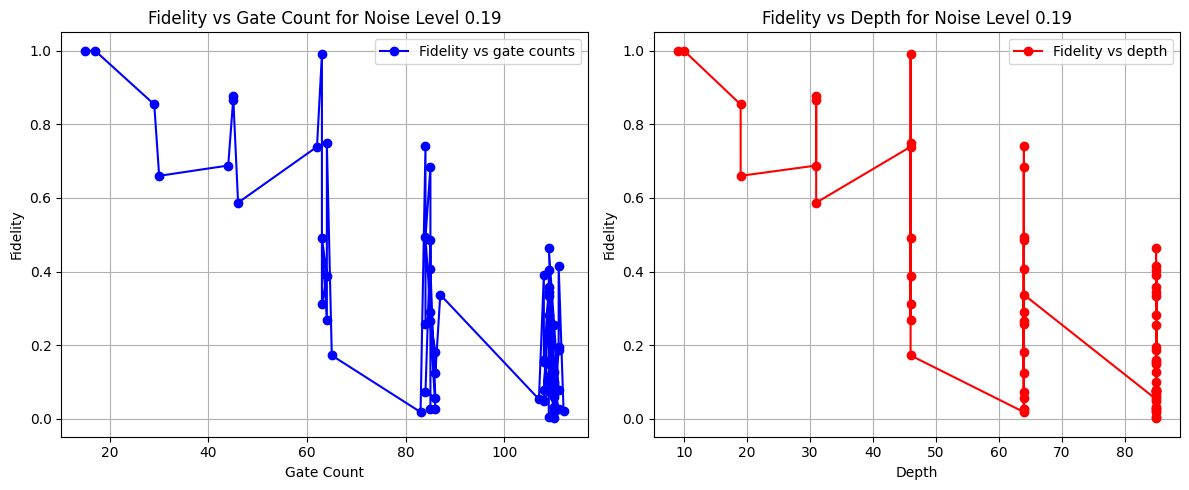

KeyboardInterrupt: 

In [90]:
# Run the analyses
a = 3
b = 2
noise_levels = np.arange(0.05,0.2,0.01)
for noise in noise_levels:
    fid_gate_count, gate_counts, depths = fidelity_vs_gate_count_and_depth(adder, max_value=64, noise_level=noise, scale = 2, shots=1000)

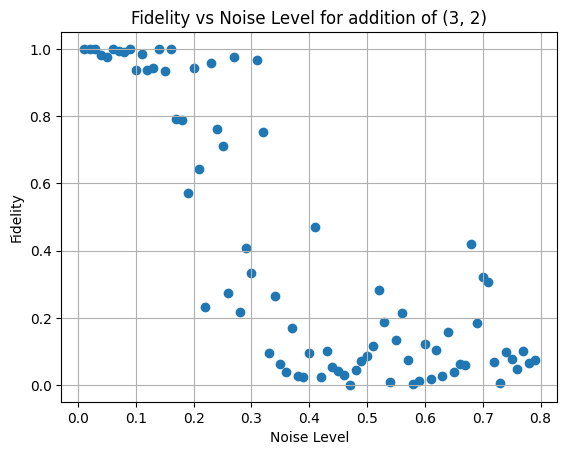

In [192]:
# Run the analyses
a = 3
b = 2
noise_levels = np.arange(0.01,0.8,0.01)
fid_vs_noise = fidelity_vs_noise(adder(a, b), noise_levels, 2,10000)

Correlation coefficient: -0.818684973924266


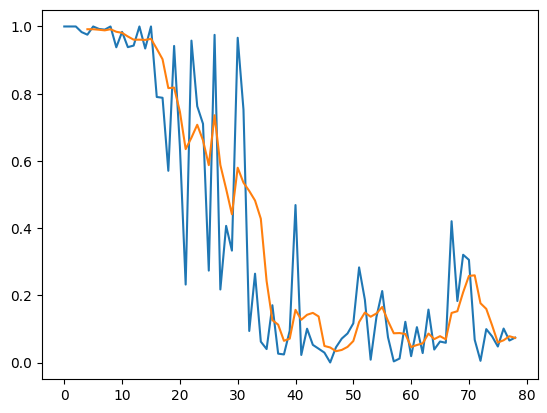

In [193]:
corr_coeff(fid_vs_noise, noise_levels)
plot_rolling_average(fid_vs_noise, 5)

#### Results and Analysis:
In this project, we examined the effects of noise on quantum addition using the Draper adder algorithm and analyzed how noise impacts the accuracy of the computation at various levels. To achieve this, we generated noisy versions of the adder circuit, applied the noise model based on Pauli rotations, and assessed the fidelity of the resulting output.

##### Noise Impact on Addition Accuracy:

By running the noisy circuit for various levels of single-qubit and two-qubit noise probabilities, we observed a clear degradation in the addition results as noise levels increased.
When noise was minimal (e.g., α,
β≤0.1), the Draper adder circuit managed to produce accurate addition results with occasional errors in the least significant bits.
For moderate noise levels (e.g., 
𝛼
,
𝛽
≈
0.2
α,β≈0.2), errors in the output became more frequent, indicating that even moderate noise introduces significant inaccuracies in the addition result.
For high noise levels (e.g., 
𝛼
,
𝛽
≥
0.3
α,β≥0.3), the results became unreliable, with frequent bit-flip errors, resulting in an overall drop in fidelity. At these levels, the probability of obtaining correct results diminished sharply, demonstrating how sensitive quantum circuits are to high noise.
##### Fidelity as a Benchmark:

Fidelity was used to measure the correctness of the results compared to the ideal noiseless circuit output. The average fidelity across multiple runs of the circuit decreased as noise levels increased.
We observed that circuits with higher gate counts showed lower fidelity for the same noise levels, likely due to the cumulative effect of noise introduced after each gate operation.
The noise affected two-qubit gates (such as controlled rotations) more severely, showing a notable impact on fidelity at even lower noise levels due to the entanglement they introduce.
##### Effect of Gate Basis:

Transforming the adder circuit to a restricted gate basis did introduce a few additional gates to the circuit. These additional operations also contributed to a slight increase in error likelihood.
Analysis showed that gate decomposition and basis transformations for compatibility with hardware introduce more gates, which increases the cumulative noise effect. Hence, quantum circuits that can avoid extra transformations are inherently less affected by noise.
##### Discussion:
The findings underscore the sensitivity of quantum circuits to noise and highlight the challenges of implementing complex algorithms like the Draper adder on real quantum hardware. Several key insights emerge from these results:

Noise Mitigation Strategies:

The results indicate a need for noise mitigation strategies. One approach is error correction codes (such as surface codes or repetition codes) that detect and correct common error patterns. However, implementing these strategies increases resource requirements.
##### Reducing Gate Count:

Since the cumulative effect of noise grows with gate count, optimizing quantum algorithms to minimize gates, especially two-qubit gates, is crucial. Techniques like quantum circuit optimization and redundant gate removal could reduce the number of operations.
Ideally, compiling circuits directly to the hardware-native gate set (without unnecessary basis transformations) would further reduce noise accumulation.
##### Noise-Resilient Quantum Algorithms:

For practical quantum computing, designing algorithms that are inherently robust to noise, possibly by leveraging error-tolerant encodings, will be essential. Algorithms can also incorporate adaptive noise management, modifying computations on-the-fly based on error diagnostics.
#### Scalability of the Draper Adder in Noisy Environments:

This analysis shows that while the Draper adder is theoretically promising, its reliance on entangling operations makes it challenging to scale under noisy conditions. Exploring alternatives like modular arithmetic in quantum Fourier space may offer more resilient addition methods.
In summary, this project provides a structured approach to understanding how noise affects quantum addition. It shows that even modest levels of noise substantially impact results, emphasizing the importance of both circuit optimization and error mitigation techniques in quantum computing.